## Business Understanding

### Business Problem
An urban Emergency Medical Services (EMS) agency is attempting to identify factors which they can manipulate in order to improve operational efficiency. The agency runs approximately 130,000 911 calls for service each year. Over the last several years, the agency has implemented brand new resources like basic life support, and single resource 'fly' cars in an attempt to provide the right resourfces to the right patients at the right time. Currently, the agency's primary operation metrics is Response Time Compliance (RTC). The RTC goal is to have a 90th percentile response time to emergent calls in 9 minutes or less.

### Objective:
- **Goal:** Analyze data to identify factors that have the most impact on RTC. Create a viable model which can provide explanitory insights into the operation impacts of RTC.

- **Key Questions:**

  1. What factors influence RTC?
  2. Can a model accurately identify cases of compliance and non-compliance?

- **Success Criteria:**

  1. Identify modifiable features which can be manipulated to hopefully improve RTC.

## Data Understanding

In [1]:
# # Data Manipulation and Analysis
import pandas as pd
import numpy as np

# # Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# # Statistical Analysis
import statsmodels.api as sm
# from scipy.stats import ttest_ind, kstest, mannwhitneyu, norm
from helper import ks_test_normality, mann_whitney_test, plot_kde_with_groups

# # Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# # Preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Model Evaluation
from sklearn.metrics import (
    # accuracy_score,
    classification_report,
    confusion_matrix,
    # roc_auc_score,
    # roc_curve,
    f1_score,
    precision_score,
    recall_score,
    make_scorer
    # mean_squared_error,
    # mean_absolute_error,
    # r2_score,
    # auc
)

# # Class Weight Evaluation
# from sklearn.utils.class_weight import compute_class_weight

# Model Selection and Cross-Validation
from sklearn.model_selection import (
    GridSearchCV,
    # RandomizedSearchCV,
    train_test_split,
    # StratifiedKFold,
    cross_val_score
)

# Pipelines
from sklearn.pipeline import Pipeline

In [2]:
# Data loading and preview

data = pd.read_csv('data/ems_ops.csv')
data.head()

,year,month,day,day_of_week,hour,incident_count,dist_mean,perc_from_hosp,base_ed_divert,system_overload,...,fly_cars,total_cars,non_emergent_transports,emergent_transports,chute_times_all,chute_times_non_emergent,chute_times_emergent,temperature,rain,snowfall
0,2014,11,1,Sat,0,13,1.585860,0.153846,0,0,...,0.0,0.0,6.0,1.0,NaN,NaN,NaN,12.2545,0.0,0.0
1,2014,11,1,Sat,1,24,3.213414,0.166667,0,0,...,0.0,0.0,14.0,NaN,NaN,NaN,NaN,10.3545,0.0,0.0
2,2014,11,1,Sat,2,26,2.709078,0.269231,1,1,...,0.0,0.0,16.0,2.0,NaN,NaN,NaN,8.7045,0.0,0.0
3,2014,11,1,Sat,3,8,3.461524,0.375000,1,1,...,0.0,0.0,14.0,NaN,NaN,NaN,NaN,7.2545,0.0,0.0
4,2014,11,1,Sat,4,6,1.970146,0.000000,1,1,...,0.0,0.0,2.0,2.0,NaN,NaN,NaN,5.5045,0.0,0.0


In [3]:
# Data overview
# Set the option to display all columns
pd.set_option('display.max_columns', None)

data.describe()

,year,month,day,hour,incident_count,dist_mean,perc_from_hosp,base_ed_divert,system_overload,weather_status,RTC,emergent_responses,non_emergent_responses,mean_response_all,mean_response_emergent,mean_response_non_emergent,percentile_90_response_all,percentile_90_response_emergent,percentile_90_response_non_emergent,bls_ambulances,satellite_ambulances,als_ambulances,fly_cars,total_cars,non_emergent_transports,emergent_transports,chute_times_all,chute_times_non_emergent,chute_times_emergent,temperature,rain,snowfall
count,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,87088.000000,85726.000000,28370.000000,51483.000000,45528.000000,51237.000000,87088.000000,87088.000000,87088.000000
mean,2019.340185,6.523964,15.732569,11.544817,12.329242,3.877920,0.143623,0.117008,0.249070,0.006752,0.882147,7.742766,3.068632,434.538436,358.594131,578.353522,687.013872,508.327457,751.153516,0.130614,0.860627,13.295030,0.076501,14.362772,7.479085,1.307367,105.773613,122.724327,99.096213,9.601541,0.033006,0.012297
std,2.896795,3.448693,8.802954,6.914466,5.203629,27.129300,0.120634,0.321432,0.432477,0.081892,0.153357,3.729647,1.979666,97.731440,86.116725,273.714230,205.475725,146.660822,364.075128,0.449150,0.978303,5.596428,0.267326,5.838694,3.783527,0.617571,30.097419,71.723473,29.612193,11.994113,0.238435,0.088175
min,2014.000000,1.000000,1.000000,0.000000,1.000000,0.008578,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.538462,1.000000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,1.130000,1.696000,-36.645000,0.000000,0.000000
25%,2017.000000,4.000000,8.000000,6.000000,8.000000,2.112666,0.055556,0.000000,0.000000,0.000000,0.800000,5.000000,2.000000,366.750000,301.727273,438.500000,538.900000,412.500000,545.300000,0.000000,0.000000,8.758889,0.000000,9.546389,5.000000,1.000000,87.500000,82.446550,81.000000,0.204500,0.000000,0.000000
50%,2019.000000,7.000000,16.000000,12.000000,12.000000,2.581790,0.130435,0.000000,0.000000,0.000000,0.923077,7.000000,3.000000,426.000000,348.750000,580.750000,657.500000,487.000000,753.000000,0.000000,1.000000,14.000000,0.000000,15.000000,7.000000,1.000000,101.857143,109.333333,95.441400,9.655001,0.000000,0.000000
75%,2022.000000,10.000000,23.000000,18.000000,16.000000,3.157333,0.214286,0.000000,0.000000,0.000000,1.000000,10.000000,4.000000,492.538462,403.960526,735.000000,804.025000,578.800000,983.500000,0.000000,1.729167,18.000000,0.000000,19.108681,10.000000,1.000000,119.156316,144.827333,112.500000,18.604500,0.000000,0.000000
max,2024.000000,12.000000,31.000000,23.000000,88.000000,2623.566100,1.000000,1.000000,1.000000,1.000000,1.000000,27.000000,15.000000,1541.000000,1732.000000,1801.000000,1795.000000,1742.500000,1801.000000,6.000000,5.487778,37.828611,2.000000,45.579722,26.000000,11.000000,971.000000,3599.870000,944.440333,38.305000,11.400000,3.500000


In [4]:
# Values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87088 entries, 0 to 87087
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   year                                 87088 non-null  int64  
 1   month                                87088 non-null  int64  
 2   day                                  87088 non-null  int64  
 3   day_of_week                          87088 non-null  object 
 4   hour                                 87088 non-null  int64  
 5   incident_count                       87088 non-null  int64  
 6   dist_mean                            87088 non-null  float64
 7   perc_from_hosp                       87088 non-null  float64
 8   base_ed_divert                       87088 non-null  int64  
 9   system_overload                      87088 non-null  int64  
 10  weather_status                       87088 non-null  int64  
 11  RTC                         

## Data Preparation

In [5]:
# Check to see how many chute_times_emergent is null
data['chute_times_emergent'].isnull().value_counts()

chute_times_emergent
False    51237
True     35851
Name: count, dtype: int64

In [6]:
# Finding first index where chute time(s) aren't null
first_valid_index = data['chute_times_all'].first_valid_index()
print(first_valid_index)

# Looks like the majority of the early data isn't valid. Too much to impute so I'll drop those
data = data.loc[first_valid_index:]

35199


In [7]:
# Missing values

# tx_counts - if null consider 0
data['non_emergent_transports'] = data['non_emergent_transports'].fillna(0)
data['emergent_transports'] = data['emergent_transports'].fillna(0)
# chute times - impute
knn_imputer = KNNImputer(n_neighbors=5) # Taking the mean value from 5 most similar rows
chute_times = ['chute_times_all', 'chute_times_non_emergent', 'chute_times_emergent']
data[chute_times] = knn_imputer.fit_transform(data[chute_times])

In [8]:
# total_cars min is 0, this should never happen, dropping rows where < 1
data = data[data['total_cars'] >= 1]

In [9]:
# dist_mean: mean + 1 std is roughly the diameter of the city
# Calculate the upper limit
k = 1
mean = data['dist_mean'].mean()
std_dev = data['dist_mean'].std()
upper_limit = mean + k * std_dev

# Filter the dataset
data = data[data['dist_mean'] <= upper_limit]

In [10]:
# Going to drop features that are derivatives of others or otherwise not needed
data = data.drop(columns=['mean_response_all',
                          'mean_response_emergent',
                          'mean_response_non_emergent',
                          'percentile_90_response_all',
                          'RTC',
                          'incident_count',
                          'system_overload'])

In [11]:
# Feature engineering

# tx_per_ambulance: Transports per transporting car
data['tx_per_ambulance'] = np.where(
    (data['als_ambulances'] + data['bls_ambulances'] + data['satellite_ambulances']) == 0,
    0,
    (data['non_emergent_transports'] + data['emergent_transports']) / (data['als_ambulances'] + data['bls_ambulances'] + data['satellite_ambulances'])
)

# resp_per_ambulance: Responses per responding unit
data['resp_per_ambulance'] = np.where(
    data['total_cars'] == 0,
    0,
    (data['emergent_responses'] + data['non_emergent_responses']) / data['total_cars']
)

# als_resources_per_emergent_response: ALS resources per emergent response
data['als_resources_per_emergent_response'] = np.where(
    data['emergent_responses'] == 0,
    0,
    (data['als_ambulances'] + data['satellite_ambulances'] + data['fly_cars']) / data['emergent_responses']
)

# Lags and diffs
data['emergent_responses_lag1'] = data['emergent_responses'].shift(1)
data['non_emergent_responses_lag1'] = data['non_emergent_responses'].shift(1)
data['base_ed_divert_lag1'] = data['base_ed_divert'].shift(1)
data['non_emergent_transports_lag1'] = data['non_emergent_transports'].shift(1)
data['emergent_transports_lag1'] = data['emergent_transports'].shift(1)
data['percentile_90_response_emergent_lag1'] = data['percentile_90_response_emergent'].shift(1)
data['percentile_90_response_emergent_lag2'] = data['percentile_90_response_emergent'].shift(2)

data['total_cars_dif1'] = data['total_cars'].diff()
data['als_ambulances_dif1'] = data['als_ambulances'].diff()
data['bls_ambulances_dif1'] = data['bls_ambulances'].diff()
data['satellite_ambulances_dif1'] = data['satellite_ambulances'].diff()
data['fly_cars_dif1'] = data['fly_cars'].diff()

# Testing features
data['is_peak'] = data['hour'].apply(lambda x: 1 if 7 <= x <= 21 else 0) # Flagging peak times
data['overload_flag'] = (data['emergent_responses'] + data['non_emergent_responses']) > data['total_cars'] # Flag if more calls than cars
data['emergent_ratio'] = np.where(
    (data['emergent_responses'] + data['non_emergent_responses']) == 0,
    0,  # Set ratio to 0 when there are no responses
    data['emergent_responses'] / (data['emergent_responses'] + data['non_emergent_responses'])
) # Proportion of emergent vs. non-emergent calls
data['rolling_emergent_avg'] = data['emergent_responses'].rolling(7).mean() # 7 hour rolling average of emergent responses

# Interaction between distance and peak hours
data['dist_mean_is_peak'] = data['dist_mean'] * data['is_peak']

# Interaction between transports per ambulance and peak hours
data['tx_per_ambulance_is_peak'] = data['tx_per_ambulance'] * data['is_peak']

# Interaction between responses per ambulance and emergent ratio
data['resp_emergent_interaction'] = data['resp_per_ambulance'] * data['emergent_ratio']

# Lagged rolling emergent average
data['rolling_emergent_avg_lag1'] = data['rolling_emergent_avg'].shift(1)

# Interaction between rolling average and lagged response time
data['rolling_emergent_avg_interaction'] = data['rolling_emergent_avg'] * data['percentile_90_response_emergent_lag1']

# Utilization efficiency
data['utilization_efficiency'] = data['resp_per_ambulance'] / (data['tx_per_ambulance'] + 1e-9)

# Dropping NaNs created by lag and diff features
data = data.dropna()

In [12]:
# Handle encoding
data = pd.get_dummies(data, columns=['day_of_week'], drop_first=True)

## Exploratory Data Analysis (EDA)

In [13]:
# Checking for any remaining non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51530 entries, 35206 to 87087
Data columns (total 56 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   year                                  51530 non-null  int64  
 1   month                                 51530 non-null  int64  
 2   day                                   51530 non-null  int64  
 3   hour                                  51530 non-null  int64  
 4   dist_mean                             51530 non-null  float64
 5   perc_from_hosp                        51530 non-null  float64
 6   base_ed_divert                        51530 non-null  int64  
 7   weather_status                        51530 non-null  int64  
 8   emergent_responses                    51530 non-null  int64  
 9   non_emergent_responses                51530 non-null  float64
 10  percentile_90_response_emergent       51530 non-null  float64
 11  percentile_90_re

In [14]:
# One last inspection
data.describe()

,year,month,day,hour,dist_mean,perc_from_hosp,base_ed_divert,weather_status,emergent_responses,non_emergent_responses,percentile_90_response_emergent,percentile_90_response_non_emergent,bls_ambulances,satellite_ambulances,als_ambulances,fly_cars,total_cars,non_emergent_transports,emergent_transports,chute_times_all,chute_times_non_emergent,chute_times_emergent,temperature,rain,snowfall,tx_per_ambulance,resp_per_ambulance,als_resources_per_emergent_response,emergent_responses_lag1,non_emergent_responses_lag1,base_ed_divert_lag1,non_emergent_transports_lag1,emergent_transports_lag1,percentile_90_response_emergent_lag1,percentile_90_response_emergent_lag2,total_cars_dif1,als_ambulances_dif1,bls_ambulances_dif1,satellite_ambulances_dif1,fly_cars_dif1,is_peak,emergent_ratio,rolling_emergent_avg,dist_mean_is_peak,tx_per_ambulance_is_peak,resp_emergent_interaction,rolling_emergent_avg_lag1,rolling_emergent_avg_interaction,utilization_efficiency
count,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,5.153000e+04,51530.000000,5.153000e+04,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,51530.000000,5.153000e+04
mean,2021.360605,6.482554,15.776965,11.541568,2.753905,0.144996,0.147467,0.011275,8.028469,2.946749,531.589206,748.928733,0.190298,1.448909,13.097830,0.119149,14.856186,8.217039,0.530681,105.754793,120.239177,99.150728,9.622455,0.028508,0.011871,0.724724,0.900917,2.293291,8.028430,2.946594,0.147467,8.216942,0.530681,531.588834,531.591747,0.000315,0.000296,8.618071e-20,0.000019,3.124051e-20,0.627925,0.728890,8.028280,1.658246,0.491853,0.665960,8.028203,4320.294375,1.052437e+06
std,1.729754,3.439231,8.811299,6.920139,0.905744,0.120348,0.354575,0.105584,3.812080,1.945381,155.618917,373.184025,0.550969,0.872442,5.946379,0.316518,6.283968,3.668762,0.774103,29.908572,68.592583,29.636741,12.210182,0.233577,0.089334,0.558220,0.666009,1.855676,3.812081,1.945297,0.354575,3.668781,0.774103,155.619076,155.616977,2.091192,2.022201,1.562040e-01,0.400079,1.558582e-01,0.483363,0.159994,2.463305,1.405244,0.564560,0.544642,2.463351,1990.547990,3.528166e+07
min,2018.000000,1.000000,1.000000,0.000000,0.008578,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000,1.130000,1.696000,-36.645000,0.000000,0.000000,0.000000,0.049086,0.100000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-19.115556,-16.615000,-2.616389e+00,-2.593333,-1.731111e+00,0.000000,0.100000,1.285714,0.000000,0.000000,0.038115,1.285714,3.714286,1.111111e-01
25%,2020.000000,4.000000,8.000000,6.000000,2.139313,0.058824,0.000000,0.000000,5.000000,1.000000,428.000000,541.600000,0.000000,1.000000,8.446389,0.000000,9.699167,5.000000,0.000000,87.625000,82.000000,81.100708,-0.245000,0.000000,0.000000,0.421506,0.531354,1.265250,5.000000,1.000000,0.000000,5.000000,0.000000,428.000000,428.000000,-1.729722,-1.624097,0.000000e+00,0.000000,0.000000e+00,0.000000,0.625000,6.000000,0.000000,0.000000,0.363636,6.000000,2887.353571,1.000000e+00
50%,2021.000000,6.000000,16.000000,12.000000,2.611946,0.133333,0.000000,0.000000,8.000000,3.000000,507.500000,754.300000,0.000000,1.220000,13.746250,0.000000,15.661667,8.000000,0.000000,102.083333,107.618850,95.700000,9.455000,0.000000,0.000000,0.592571,0.735191,1.845302,8.000000,3.000000,0.000000,8.000000,0.000000,507.500000,507.500000,0.253056,0.223611,0.000000e+00,0.000000,0.000000e+00,1.000000,0.750000,8.000000,2.038804,0.453642,0.534691,8.000000,3971.657143,1.250000e+00
75%,2023.000000,9.000000,2

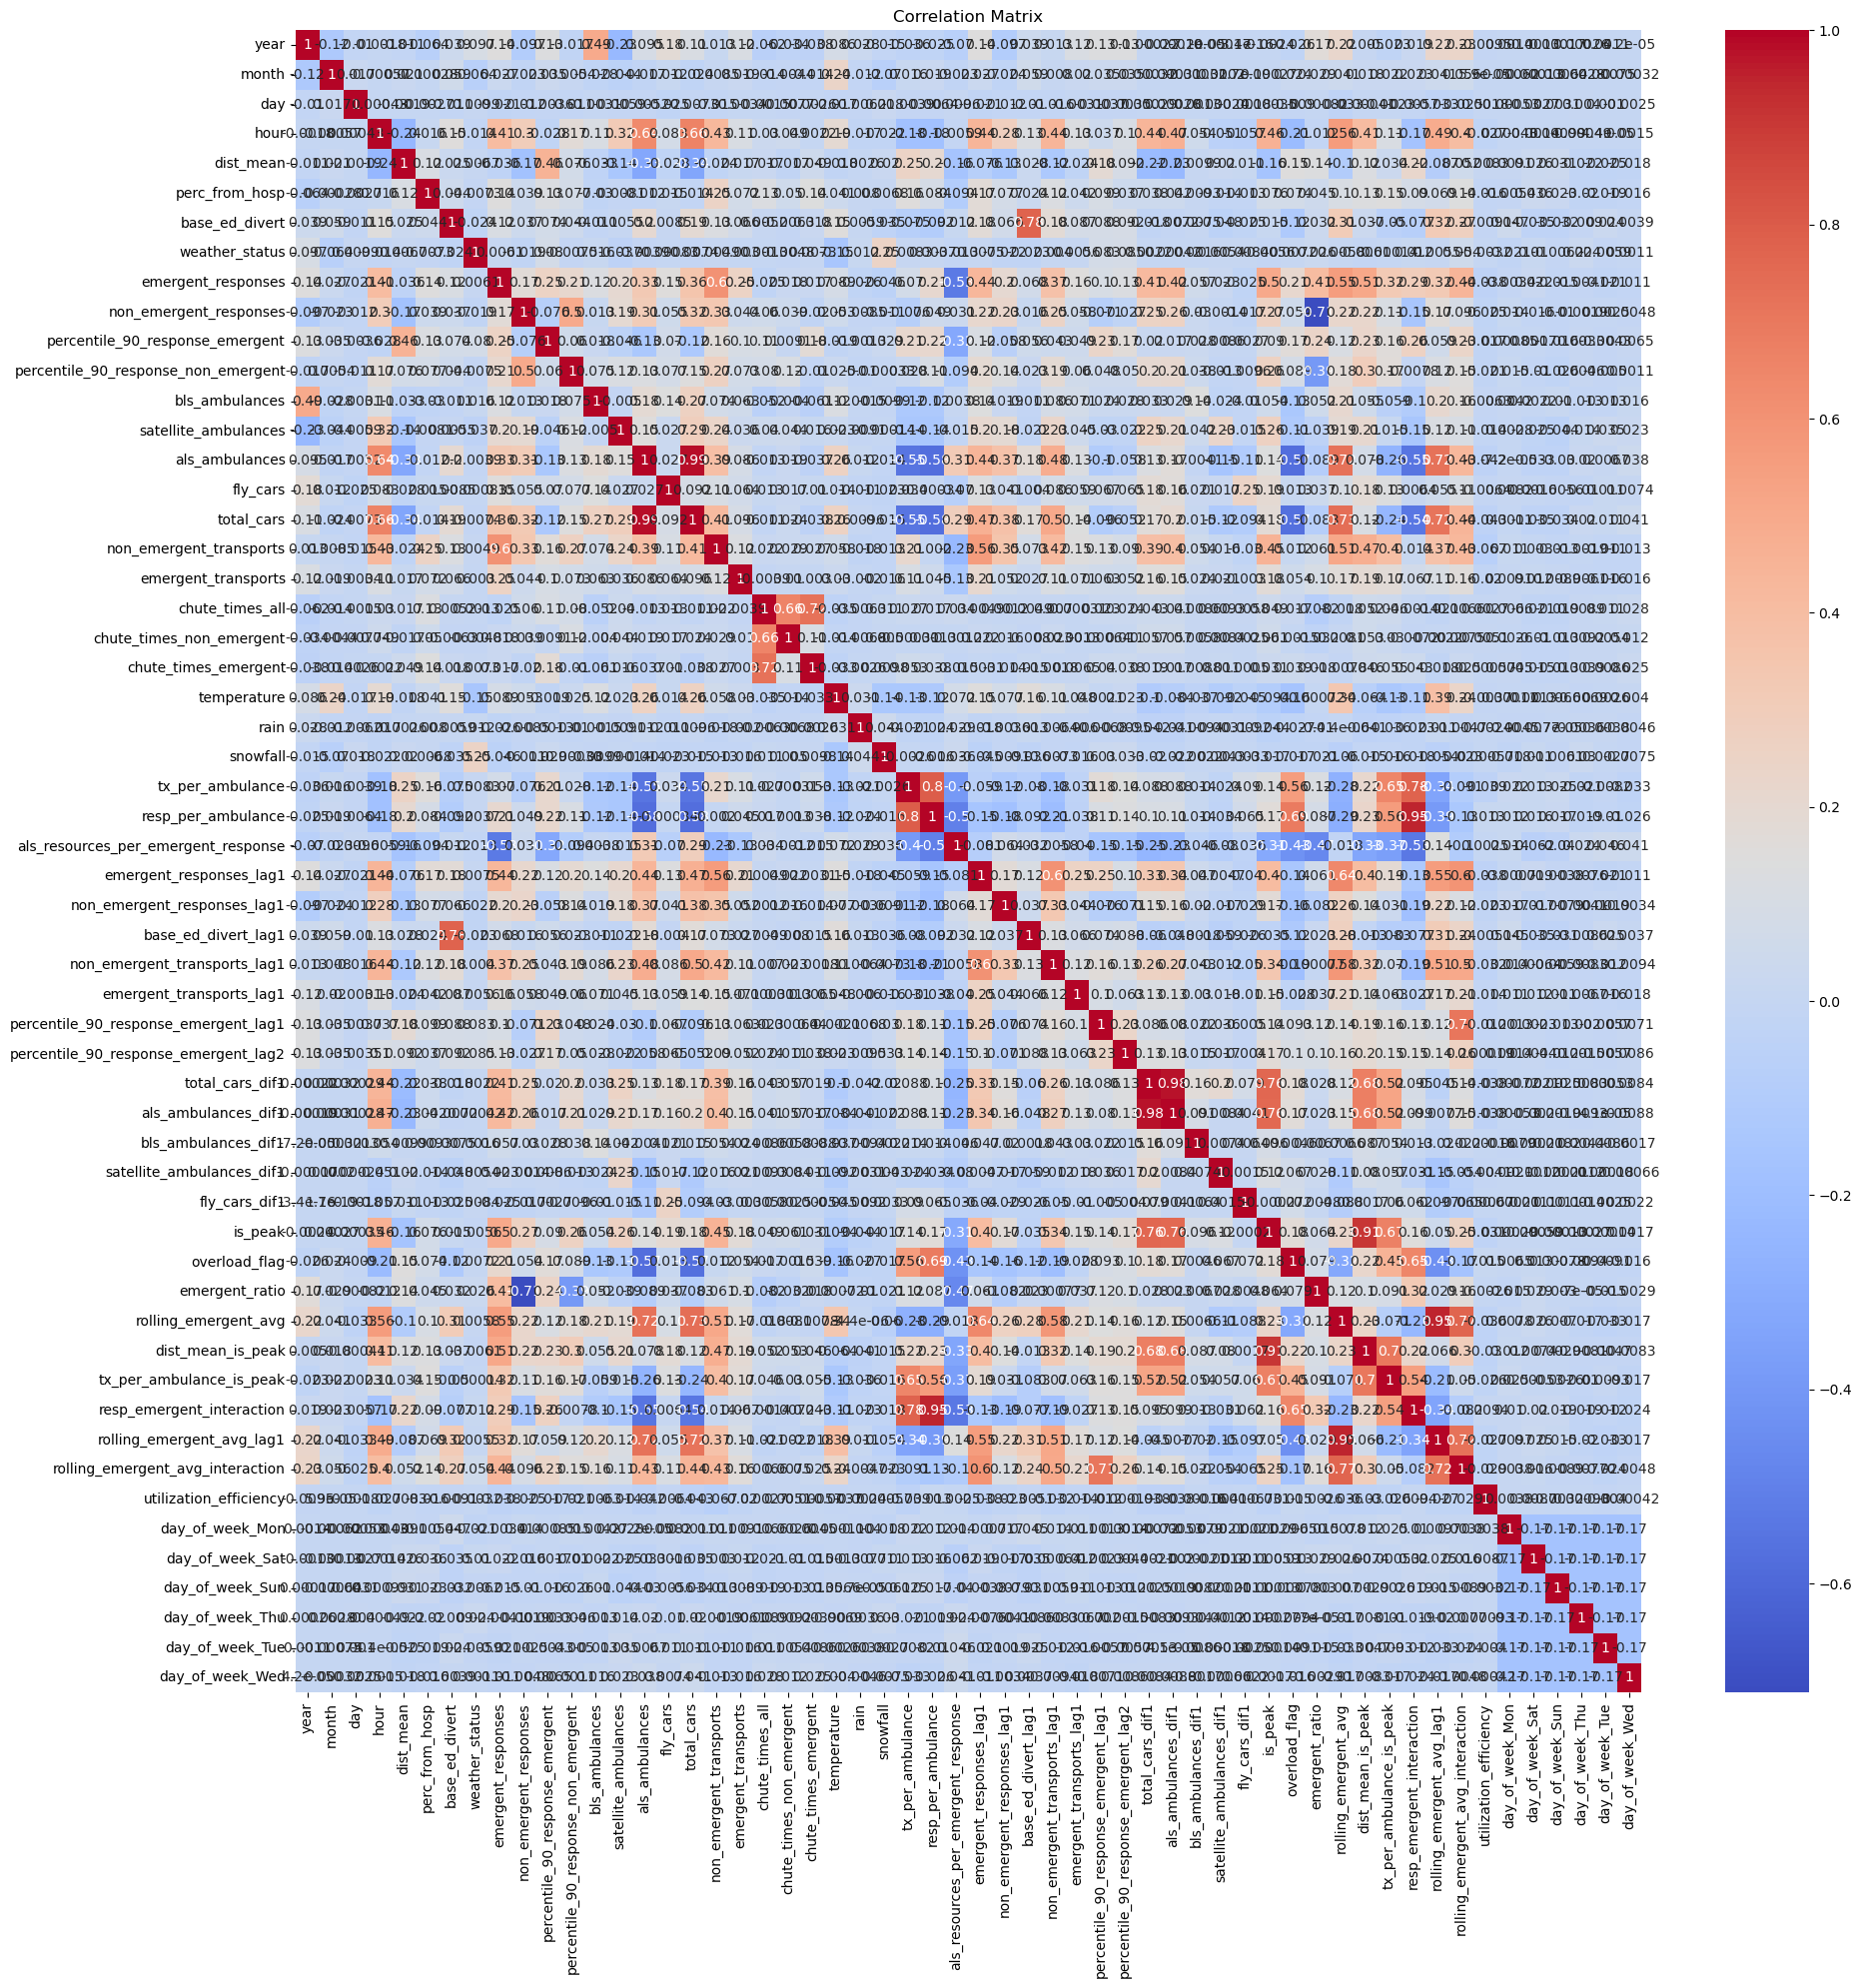

In [15]:
# Creating and visualizing a correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [16]:
# Correlation matrix is huge, let's parse it down
target_variable = 'percentile_90_response_emergent'

# Calculate correlations with the target variable
correlations = data.corr()[target_variable]

# Filter features with absolute correlation greater than 0.1
significant_features = correlations[correlations.abs() > 0.1]

# Order by absolute value of the correlations
significant_features = significant_features.reindex(
    significant_features.abs().sort_values(ascending=False).index
)

# Print the results
print("Features with |correlation| > 0.1 with the target, ordered by correlation strength:")
print(significant_features)

Features with |correlation| > 0.1 with the target, ordered by correlation strength:
percentile_90_response_emergent         1.000000
dist_mean                               0.456259
als_resources_per_emergent_response    -0.318765
resp_emergent_interaction               0.259075
emergent_responses                      0.252853
emergent_ratio                          0.238311
percentile_90_response_emergent_lag1    0.231315
rolling_emergent_avg_interaction        0.231216
dist_mean_is_peak                       0.230259
resp_per_ambulance                      0.217054
tx_per_ambulance                        0.214326
chute_times_emergent                    0.178529
overload_flag                           0.169778
percentile_90_response_emergent_lag2    0.168347
non_emergent_transports                 0.164000
tx_per_ambulance_is_peak                0.161202
year                                    0.132169
als_ambulances                         -0.130587
perc_from_hosp                    

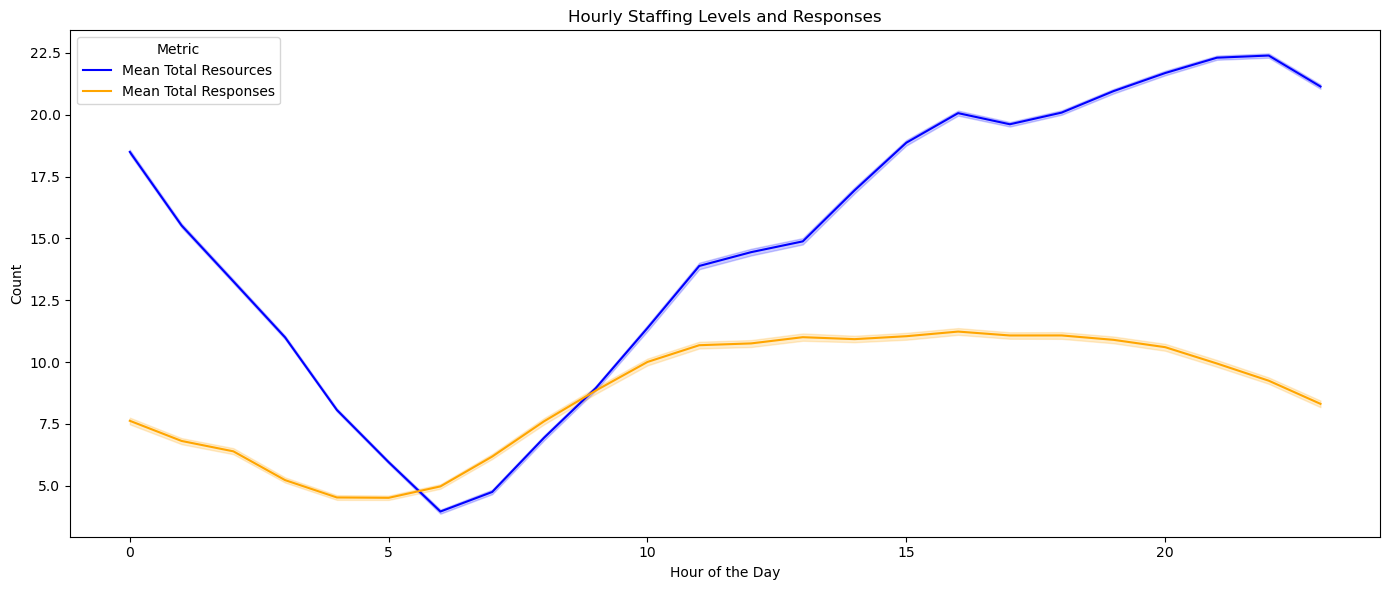

In [17]:
# First I want to inspect the obvious, is the agency making attempts to correctly staff for call volume?

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Plot hourly staffing levels
sns.lineplot(data=data, x='hour', y='total_cars', label='Mean Total Resources', color='blue', ax=ax)

# Plot hourly responses
sns.lineplot(data=data, x="hour", y=(data['non_emergent_transports'] + data['emergent_transports']), label='Mean Total Responses', color='orange', ax=ax)

# Add title and axis labels
ax.set_title("Hourly Staffing Levels and Responses")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Count")
ax.legend(title="Metric")

# Display the plot
plt.tight_layout()
plt.show()

Count of <= 540: 30729
Count of > 540: 20801


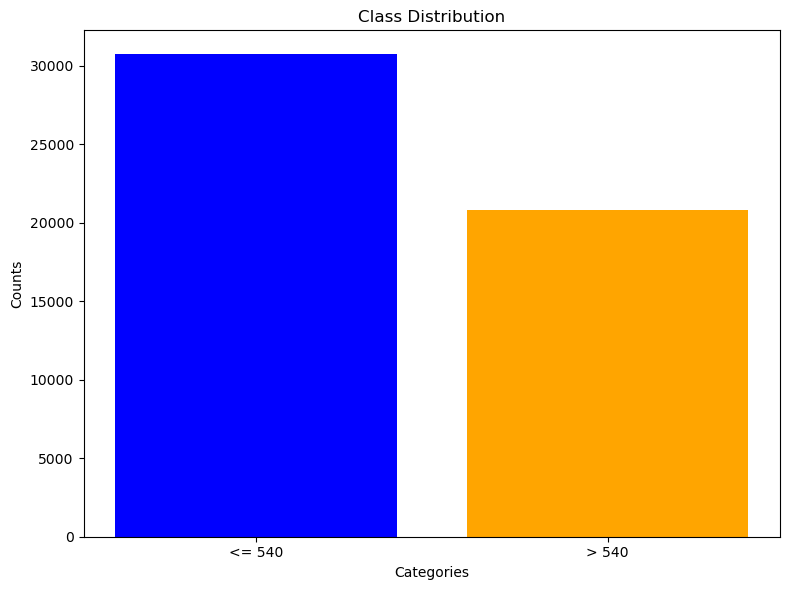

In [18]:
# Calculate counts
less_equal_540 = (data['percentile_90_response_emergent'] <= 540).sum()
greater_540 = (data['percentile_90_response_emergent'] > 540).sum()

# Print counts
print(f"Count of <= 540: {less_equal_540}")
print(f"Count of > 540: {greater_540}")

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(['<= 540', '> 540'], [less_equal_540, greater_540], color=['blue', 'orange'])
ax.set_title("Class Distribution")
ax.set_xlabel("Categories")
ax.set_ylabel("Counts")
plt.tight_layout()
plt.show()

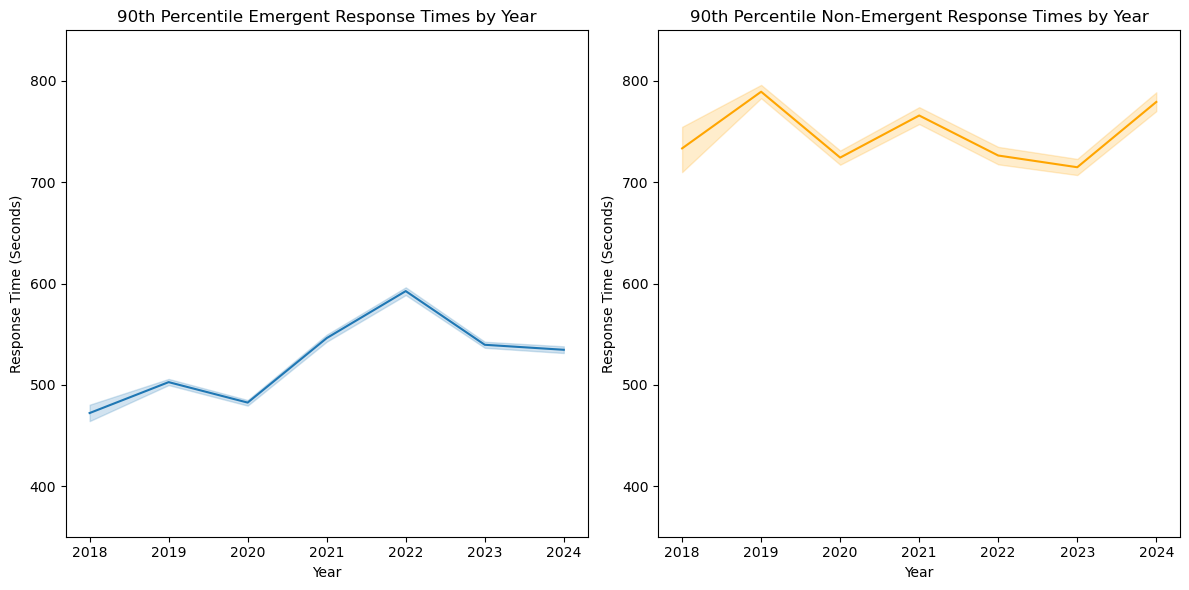

In [19]:
# Response Times for Emergent and Non-Emergent calls.

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First plot: 90th Percentile Emergent Response Times
sns.lineplot(data=data, x="year", y="percentile_90_response_emergent", ax=axes[0])
axes[0].set_title("90th Percentile Emergent Response Times by Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Response Time (Seconds)")
axes[0].set_ylim(350, 850)  # Hardcoded y-axis range

# Second plot: 90th Percentile Non-Emergent Response Times
sns.lineplot(data=data, x="year", y="percentile_90_response_non_emergent", ax=axes[1], color='orange')
axes[1].set_title("90th Percentile Non-Emergent Response Times by Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Response Time (Seconds)")
axes[1].set_ylim(350, 850)  # Hardcoded y-axis range

# Adjust layout
plt.tight_layout()
plt.show()

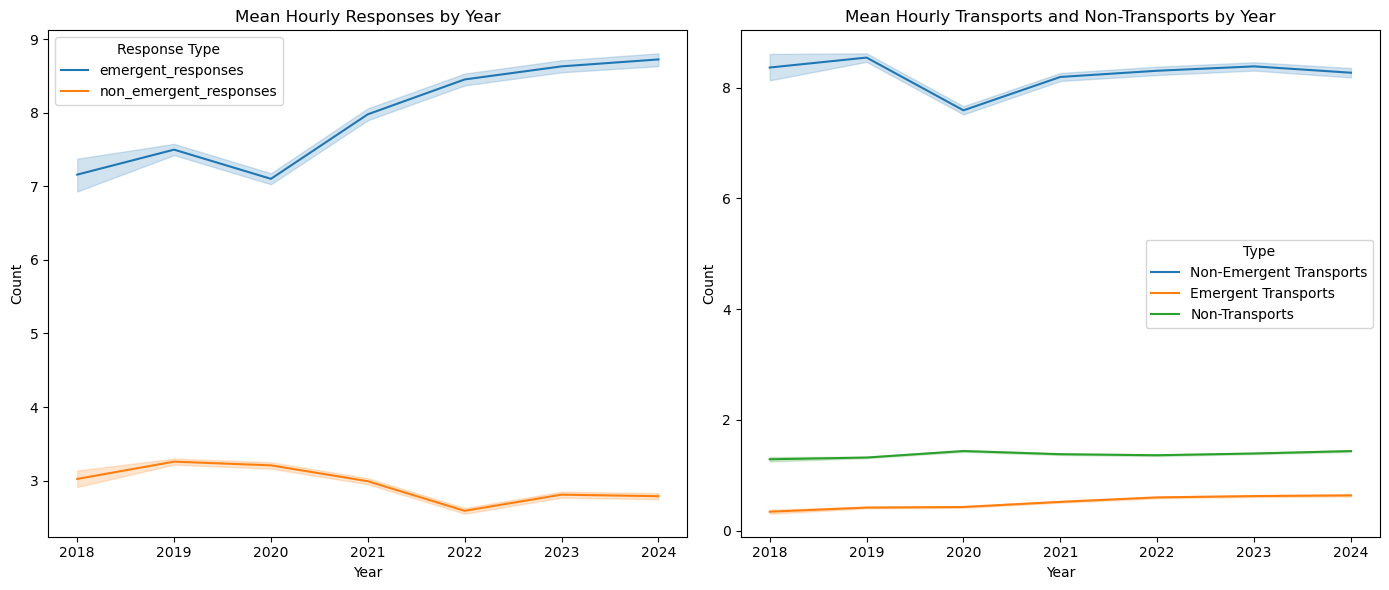

In [20]:
# Next we look at responses and transports

# Create the melted dataframe for the first chart
responses_melted = data.melt(
    id_vars='year',
    value_vars=['emergent_responses', 'non_emergent_responses'],
    var_name='Response Type',
    value_name='Count'
)

# Calculate "Transports" and "Non-Transports" for the second chart
data['Transports'] = data['non_emergent_transports'] + data['emergent_transports']

# Avoid division by zero
data['Non-Transports'] = np.where(
    data['Transports'] == 0,  # Check where Transports is zero
    0,  # Set Non-Transports to 0 if Transports is zero
    (data['emergent_responses'] + data['non_emergent_responses']) / data['Transports']  # Perform the division otherwise
)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Emergent and Non-Emergent Responses
sns.lineplot(data=responses_melted, x="year", y="Count", hue="Response Type", ax=axes[0])
axes[0].set_title("Mean Hourly Responses by Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count")
axes[0].legend(title="Response Type")

# Second plot: Transports vs Non-Transports
sns.lineplot(data=data, x="year", y="non_emergent_transports", label="Non-Emergent Transports", ax=axes[1])
sns.lineplot(data=data, x="year", y="emergent_transports", label="Emergent Transports", ax=axes[1])
sns.lineplot(data=data, x="year", y="Non-Transports", label="Non-Transports", ax=axes[1])
axes[1].set_title("Mean Hourly Transports and Non-Transports by Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count")
axes[1].legend(title="Type")

# Adjust layout
plt.tight_layout()
plt.show()

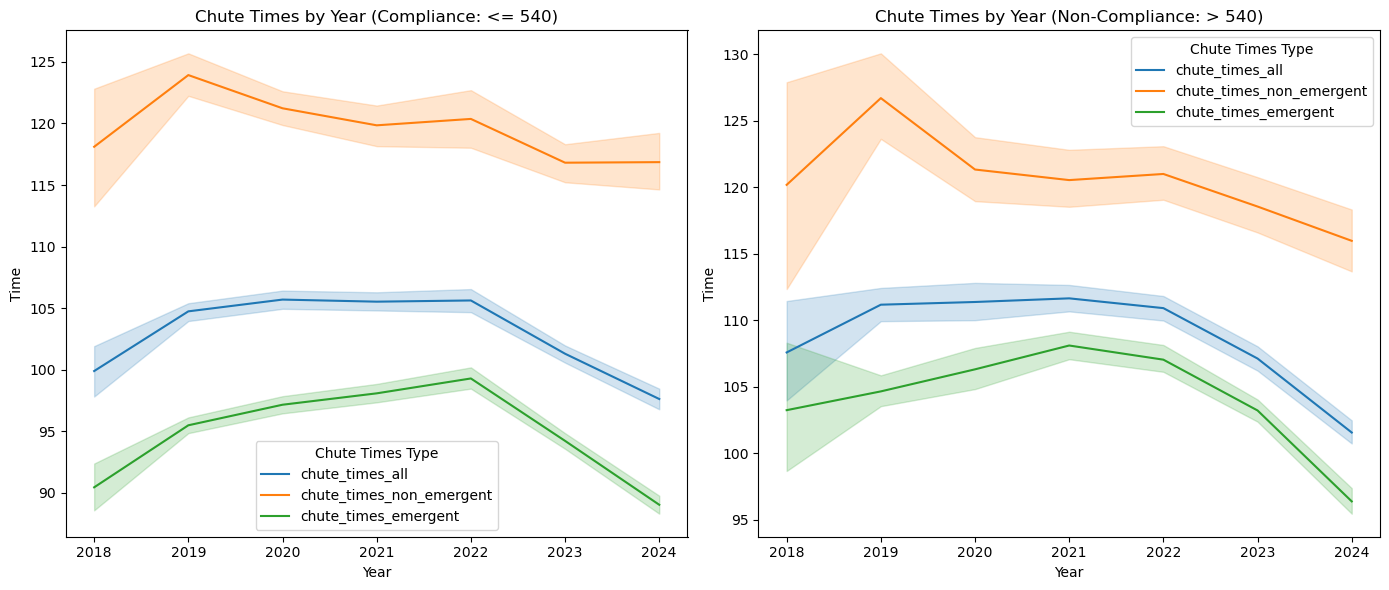

In [21]:
# Create a compliance column: 1 for <= 540, 0 for > 540
data['compliance'] = (data['percentile_90_response_emergent'] <= 540).astype(int)

# Melt the data for "Chute Times" plot, keeping compliance as part of the melted data
chutes_melted = data.melt(
    id_vars=['year', 'compliance'],
    value_vars=['chute_times_all', 'chute_times_non_emergent', 'chute_times_emergent'],
    var_name='Chute Times',
    value_name='Time'
)

# Separate the data into two groups for plotting
chutes_compliant = chutes_melted[chutes_melted['compliance'] == 1]
chutes_non_compliant = chutes_melted[chutes_melted['compliance'] == 0]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left chart: Chute times for compliant (<= 540)
sns.lineplot(data=chutes_compliant, x="year", y="Time", hue="Chute Times", ax=axes[0])
axes[0].set_title("Chute Times by Year (Compliance: <= 540)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Time")
axes[0].legend(title="Chute Times Type")

# Right chart: Chute times for non-compliant (> 540)
sns.lineplot(data=chutes_non_compliant, x="year", y="Time", hue="Chute Times", ax=axes[1])
axes[1].set_title("Chute Times by Year (Non-Compliance: > 540)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Time")
axes[1].legend(title="Chute Times Type")

# Adjust layout
plt.tight_layout()
plt.show()

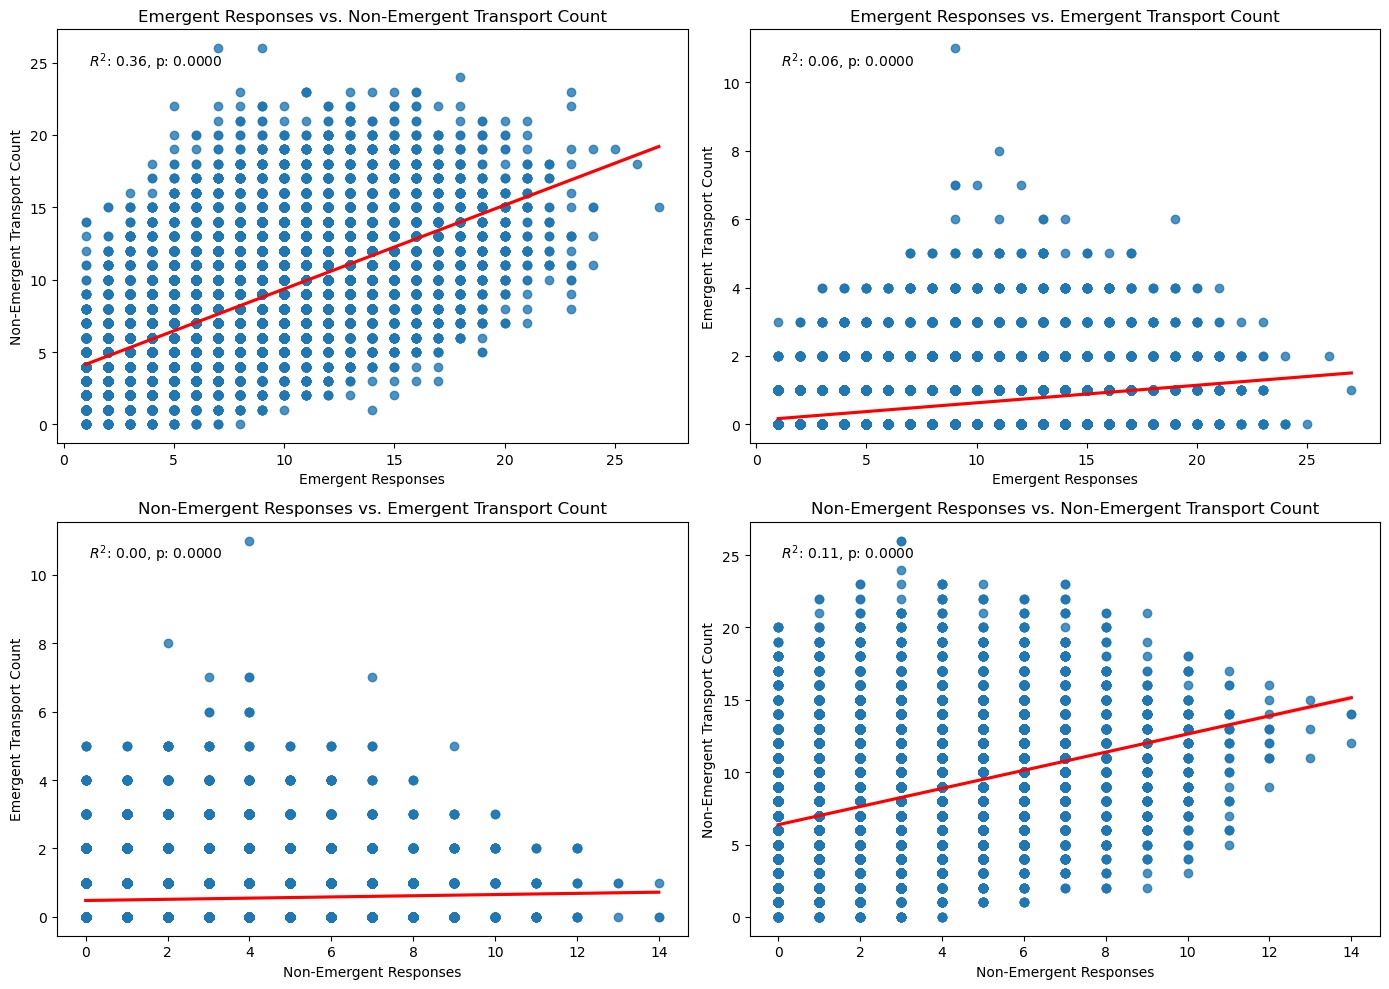

In [22]:
# Helper function to perform regression analysis
def regression_analysis(x, y):
    x = sm.add_constant(x)  # Add constant term for the intercept
    model = sm.OLS(y, x).fit()
    return model

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Emergent Responses vs. Non-Emergent Transports
sns.regplot(data=data, x='emergent_responses', y='non_emergent_transports', line_kws={'color': 'red'}, ax=axes[0, 0])
axes[0, 0].set_title("Emergent Responses vs. Non-Emergent Transport Count")
axes[0, 0].set_xlabel("Emergent Responses")
axes[0, 0].set_ylabel("Non-Emergent Transport Count")

# Perform regression and display R^2 and p-value
x = data['emergent_responses'].dropna()
y = data['non_emergent_transports'].dropna()
model = regression_analysis(x, y)
axes[0, 0].text(0.05, 0.95, f"$R^2$: {model.rsquared:.2f}, p: {model.pvalues.iloc[1]:.4f}",
                transform=axes[0, 0].transAxes, fontsize=10, verticalalignment='top')

# 2. Emergent Responses vs. Emergent Transports
sns.regplot(data=data, x='emergent_responses', y='emergent_transports', line_kws={'color': 'red'}, ax=axes[0, 1])
axes[0, 1].set_title("Emergent Responses vs. Emergent Transport Count")
axes[0, 1].set_xlabel("Emergent Responses")
axes[0, 1].set_ylabel("Emergent Transport Count")

x = data['emergent_responses'].dropna()
y = data['emergent_transports'].dropna()
model = regression_analysis(x, y)
axes[0, 1].text(0.05, 0.95, f"$R^2$: {model.rsquared:.2f}, p: {model.pvalues.iloc[1]:.4f}",
                transform=axes[0, 1].transAxes, fontsize=10, verticalalignment='top')

# 3. Non-Emergent Responses vs. Emergent Transports
sns.regplot(data=data, x='non_emergent_responses', y='emergent_transports', line_kws={'color': 'red'}, ax=axes[1, 0])
axes[1, 0].set_title("Non-Emergent Responses vs. Emergent Transport Count")
axes[1, 0].set_xlabel("Non-Emergent Responses")
axes[1, 0].set_ylabel("Emergent Transport Count")

x = data['non_emergent_responses'].dropna()
y = data['emergent_transports'].dropna()
model = regression_analysis(x, y)
axes[1, 0].text(0.05, 0.95, f"$R^2$: {model.rsquared:.2f}, p: {model.pvalues.iloc[1]:.4f}",
                transform=axes[1, 0].transAxes, fontsize=10, verticalalignment='top')

# 4. Non-Emergent Responses vs. Non-Emergent Transports
sns.regplot(data=data, x='non_emergent_responses', y='non_emergent_transports', line_kws={'color': 'red'}, ax=axes[1, 1])
axes[1, 1].set_title("Non-Emergent Responses vs. Non-Emergent Transport Count")
axes[1, 1].set_xlabel("Non-Emergent Responses")
axes[1, 1].set_ylabel("Non-Emergent Transport Count")

x = data['non_emergent_responses'].dropna()
y = data['non_emergent_transports'].dropna()
model = regression_analysis(x, y)
axes[1, 1].text(0.05, 0.95, f"$R^2$: {model.rsquared:.2f}, p: {model.pvalues.iloc[1]:.4f}",
                transform=axes[1, 1].transAxes, fontsize=10, verticalalignment='top')

# Adjust layout
plt.tight_layout()
plt.show()

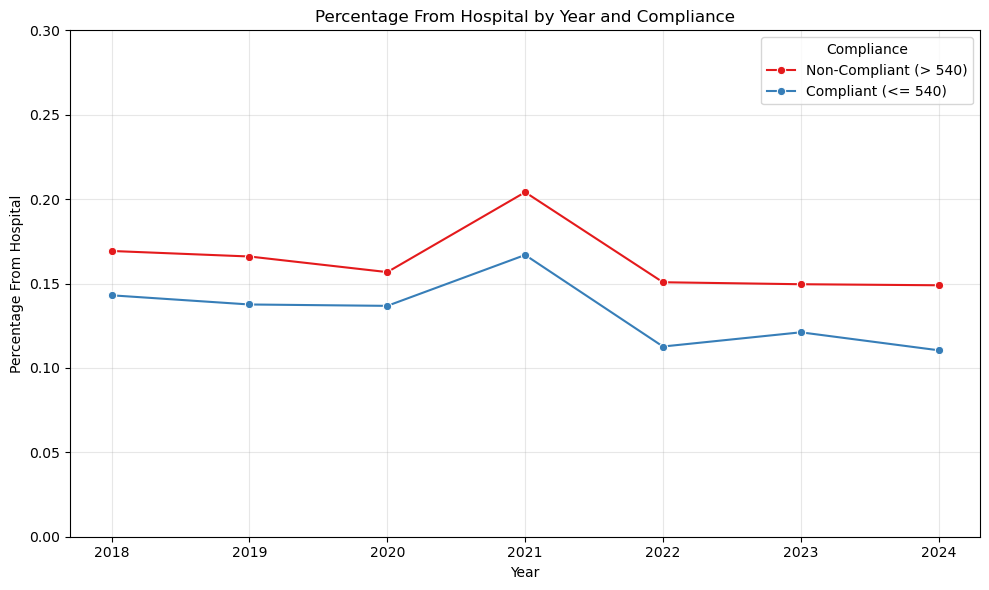

In [23]:
# perc_from_hosp

# Group the data by year and compliance, calculating the mean `perc_from_hosp`
perc_from_hosp_summary = data.groupby(['year', 'compliance'])['perc_from_hosp'].mean().reset_index()

# Map compliance values to labels
perc_from_hosp_summary['compliance'] = perc_from_hosp_summary['compliance'].map({1: 'Compliant (<= 540)', 0: 'Non-Compliant (> 540)'})

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=perc_from_hosp_summary,
    x='year',
    y='perc_from_hosp',
    hue='compliance',
    marker='o',
    palette='Set1'
)
plt.title('Percentage From Hospital by Year and Compliance')
plt.xlabel('Year')
plt.ylabel('Percentage From Hospital')
plt.ylim(0, 0.3)
plt.legend(title='Compliance')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

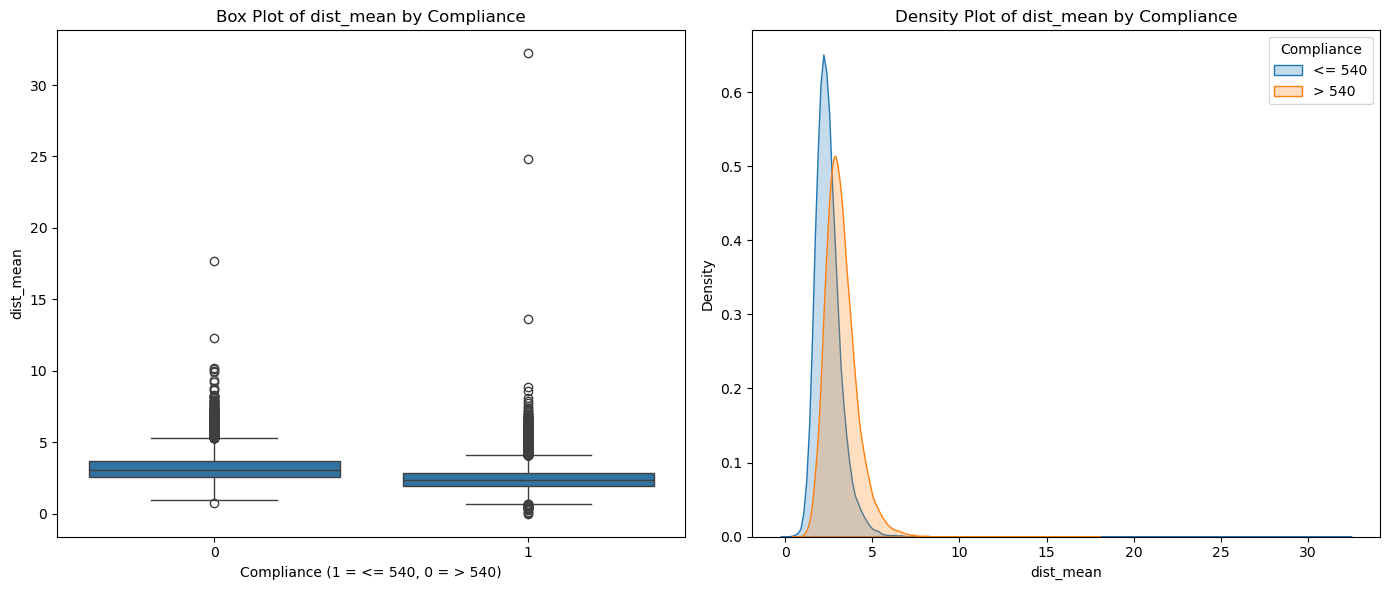

In [24]:
# Box Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for `dist_mean` by target
sns.boxplot(x='compliance', y='dist_mean', data=data, ax=ax[0])
ax[0].set_title("Box Plot of dist_mean by Compliance")
ax[0].set_xlabel("Compliance (1 = <= 540, 0 = > 540)")
ax[0].set_ylabel("dist_mean")

# Density Plot
sns.kdeplot(data[data['compliance'] == 1]['dist_mean'], label="<= 540", ax=ax[1], fill=True)
sns.kdeplot(data[data['compliance'] == 0]['dist_mean'], label="> 540", ax=ax[1], fill=True)
ax[1].set_title("Density Plot of dist_mean by Compliance")
ax[1].set_xlabel("dist_mean")
ax[1].set_ylabel("Density")
ax[1].legend(title="Compliance")

plt.tight_layout()
plt.show()

## Modeling

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.64      0.63      4160
           1       0.75      0.72      0.74      6146

    accuracy                           0.69     10306
   macro avg       0.68      0.68      0.68     10306
weighted avg       0.69      0.69      0.69     10306

F1 Score: 0.74


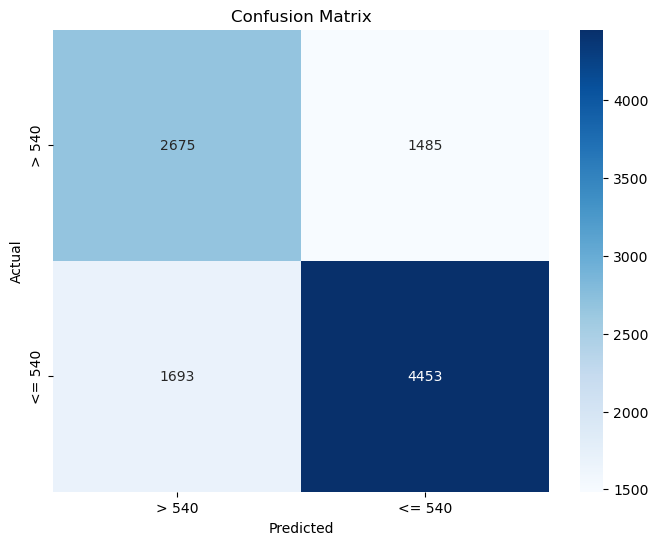

In [25]:
# Define feature and target
X = data[['dist_mean']]  # Feature(s)
y = (data['percentile_90_response_emergent'] <= 540).astype(int)  # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale features
    ('logreg', LogisticRegression(random_state=42, class_weight='balanced'))  # Step 2: Logistic Regression
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['> 540', '<= 540'], yticklabels=['> 540', '<= 540'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      4160
           1       0.80      0.74      0.77      6146

    accuracy                           0.74     10306
   macro avg       0.73      0.73      0.73     10306
weighted avg       0.74      0.74      0.74     10306

F1 Score: 0.77


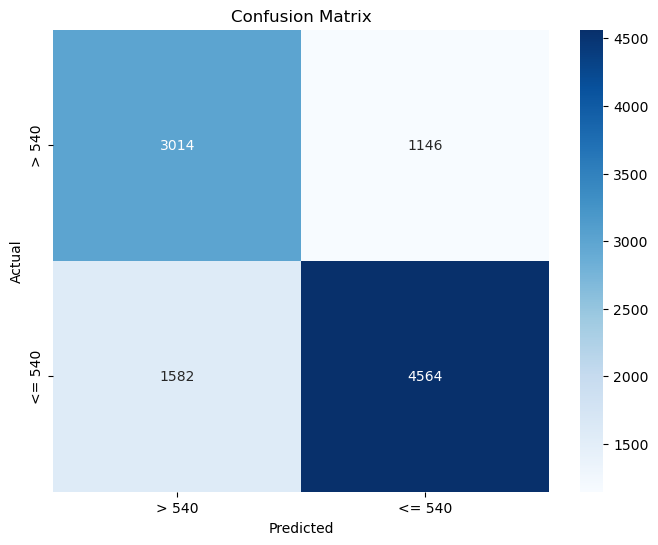

In [26]:
# Drop the target column to define features
X = data.drop(columns=['percentile_90_response_emergent', 'compliance', 'year'])  # Features
y = (data['percentile_90_response_emergent'] <= 540).astype(int)  # Target

# # Check for missing or infinite values
# print("Missing values per column:")
# print(X.isnull().sum())
# print("Infinite values per column:")
# print(np.isinf(X).sum())

# Handle missing or infinite values
X = X.replace([np.inf, -np.inf], np.nan)  # Convert infinities to NaN
X = X.fillna(X.median())  # Impute missing values with median

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale features
    ('logreg', LogisticRegression(random_state=42, class_weight='balanced'))  # Step 2: Logistic Regression
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['> 540', '<= 540'], yticklabels=['> 540', '<= 540'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [27]:
feature_coeffs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': pipeline.named_steps['logreg'].coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(feature_coeffs)


                                 Feature  Coefficient
3                              dist_mean    -0.892132
42                     dist_mean_is_peak    -0.467774
44             resp_emergent_interaction    -0.428207
46      rolling_emergent_avg_interaction    -0.370582
25   als_resources_per_emergent_response     0.353125
38                               is_peak     0.321843
19                  chute_times_emergent    -0.284801
24                    resp_per_ambulance     0.222909
7                     emergent_responses    -0.193629
41                  rolling_emergent_avg     0.151127
23                      tx_per_ambulance     0.141639
45             rolling_emergent_avg_lag1    -0.134769
17                       chute_times_all    -0.120756
6                         weather_status    -0.113361
2                                   hour     0.105413
13                              fly_cars    -0.079901
50                       day_of_week_Sun     0.077309
54                          

In [28]:
# List of features with |correlation| > 0.1
selected_features = [
    'dist_mean', 'als_resources_per_emergent_response', 'resp_emergent_interaction',
    'emergent_responses', 'emergent_ratio', 'percentile_90_response_emergent_lag1',
    'rolling_emergent_avg_interaction', 'dist_mean_is_peak', 'resp_per_ambulance',
    'tx_per_ambulance', 'chute_times_emergent', 'overload_flag',
    'percentile_90_response_emergent_lag2', 'non_emergent_transports',
    'tx_per_ambulance_is_peak', 'als_ambulances', 'perc_from_hosp',
    'total_cars', 'emergent_responses_lag1', 'rolling_emergent_avg',
    'chute_times_all', 'emergent_transports'
]

X_reduced = data[selected_features]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      4160
           1       0.80      0.74      0.76      6146

    accuracy                           0.73     10306
   macro avg       0.72      0.73      0.72     10306
weighted avg       0.74      0.73      0.73     10306

F1 Score: 0.76


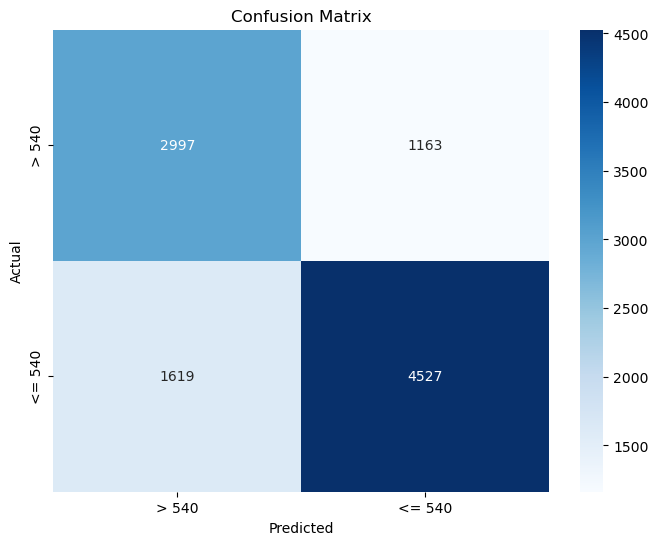

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# Define a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale features
    ('logreg', LogisticRegression(random_state=42, class_weight='balanced'))  # Step 2: Logistic Regression
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['> 540', '<= 540'], yticklabels=['> 540', '<= 540'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'logreg__C': 0.001, 'logreg__class_weight': {0: 1, 1: 1}, 'logreg__solver': 'lbfgs'}
Classification Report (Default Threshold):
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      4160
           1       0.75      0.85      0.80      6146

    accuracy                           0.74     10306
   macro avg       0.74      0.72      0.72     10306
weighted avg       0.74      0.74      0.74     10306

Best Threshold for F1 Score: 0.45
Best F1 Score: 0.8000
Classification Report at Best F1 Threshold:
              precision    recall  f1-score   support

           0       0.75      0.52      0.61      4160
           1       0.73      0.89      0.80      6146

    accuracy                           0.74     10306
   macro avg       0.74      0.70      0.71     10306
weighted avg       0.74      0.74      0.72     10306



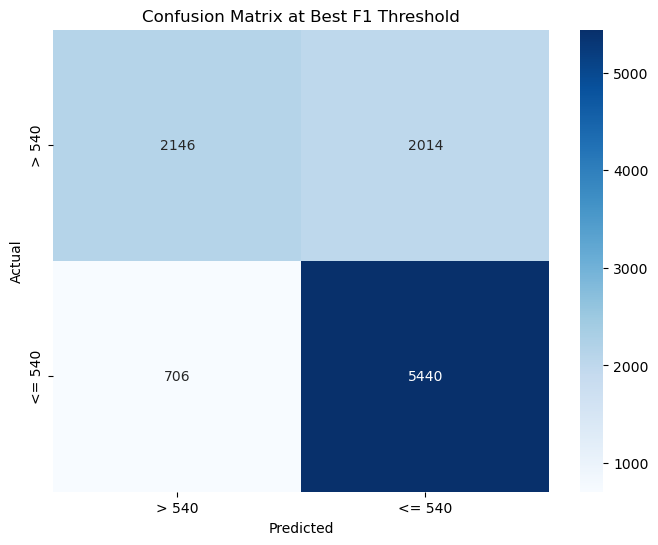

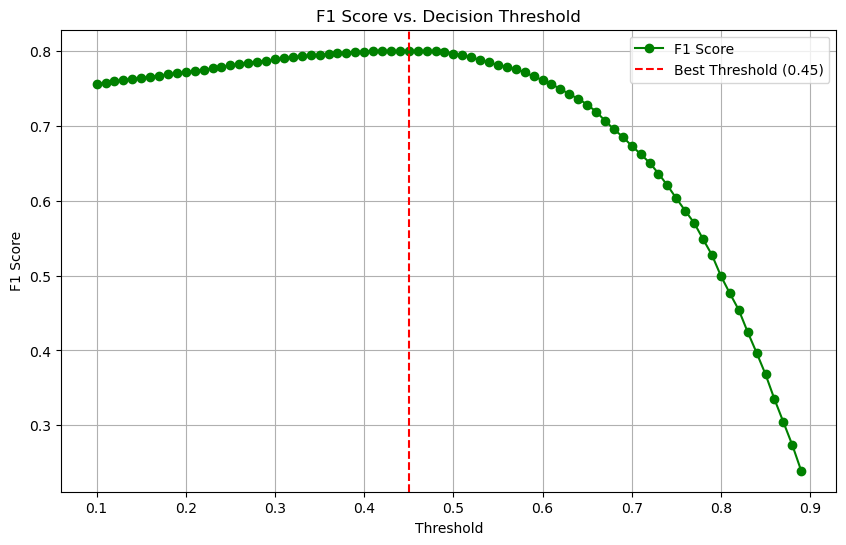

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Define parameter grid for class weights
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['liblinear', 'lbfgs', 'saga'],
    'logreg__class_weight': [
        {0: 1, 1: 0.8}, 
        {0: 1, 1: 1}, 
        {0: 2, 1: 1}, 
        {0: 3, 1: 1}, 
        'balanced'
    ]
}

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, random_state=42))
])

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1',  # Use F1 score for optimization
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test data
y_prob = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for threshold tuning
y_pred_default = best_model.predict(X_test)  # Default predictions at 0.5 threshold

# Default threshold evaluation
print("Classification Report (Default Threshold):")
print(classification_report(y_test, y_pred_default))

# F1-Focused Threshold Tuning
thresholds = np.arange(0.1, 0.9, 0.01)  # Wider range for finding the best F1 score
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# Find the best threshold for F1 Score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f"Best Threshold for F1 Score: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1_score:.4f}")

# Evaluate at the best F1 threshold
y_pred_best_thresh = (y_prob >= best_threshold).astype(int)
print("Classification Report at Best F1 Threshold:")
print(classification_report(y_test, y_pred_best_thresh))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_thresh)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['> 540', '<= 540'], yticklabels=['> 540', '<= 540'])
plt.title("Confusion Matrix at Best F1 Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot F1 Score vs. Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o', color='green')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Best Threshold ({best_threshold:.2f})")
plt.title("F1 Score vs. Decision Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.show()

Classification Report (Baseline Decision Tree):
              precision    recall  f1-score   support

           0       0.57      0.58      0.58      4160
           1       0.71      0.70      0.71      6146

    accuracy                           0.65     10306
   macro avg       0.64      0.64      0.64     10306
weighted avg       0.65      0.65      0.65     10306

F1 Score: 0.71


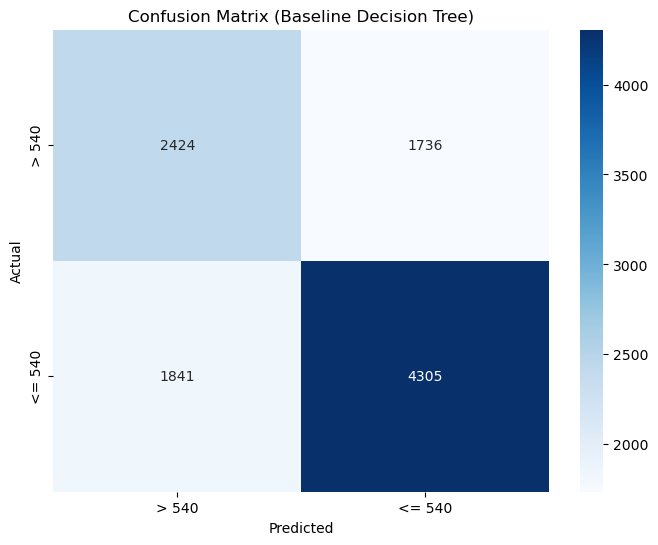

In [31]:
# I want to compare against a DecisionTreeClassifier

# Baseline Decision Tree Classifier
baseline_dtree = DecisionTreeClassifier(random_state=42)  # Default hyperparameters

# Fit the baseline model to the training data
baseline_dtree.fit(X_train, y_train)

# Predict using default threshold (0.5)
y_pred_baseline = baseline_dtree.predict(X_test)

# Evaluate baseline model performance
print("Classification Report (Baseline Decision Tree):")
print(classification_report(y_test, y_pred_baseline))

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred_baseline)
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=['> 540', '<= 540'], yticklabels=['> 540', '<= 540'])
plt.title("Confusion Matrix (Baseline Decision Tree)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters (Decision Tree): {'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report (Tuned Decision Tree):
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      4160
           1       0.75      0.81      0.78      6146

    accuracy                           0.72     10306
   macro avg       0.71      0.70      0.70     10306
weighted avg       0.72      0.72      0.72     10306

F1 Score: 0.78


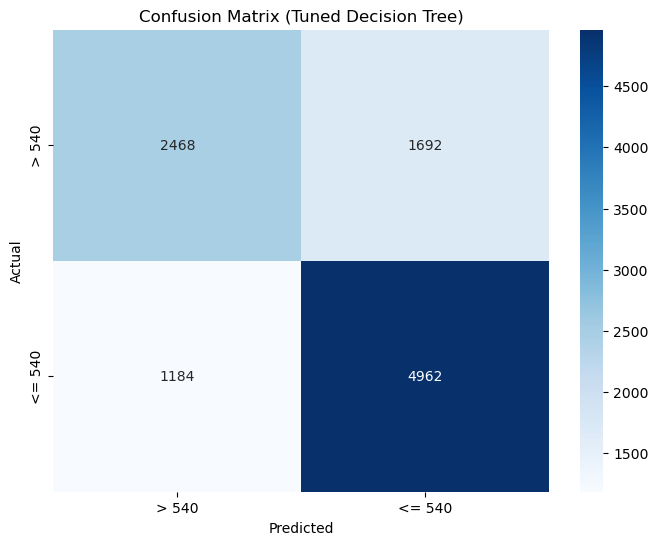

In [32]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, None],  # Vary tree depth
    'min_samples_split': [2, 5, 10],   # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],     # Minimum samples required in a leaf node
    'class_weight': [None, 'balanced'],  # Handle class imbalance
    'criterion': ['gini', 'entropy']   # Splitting criteria
}

# Decision Tree Classifier with GridSearchCV
dtree = DecisionTreeClassifier(random_state=42)
grid_search_dtree = GridSearchCV(
    dtree, 
    param_grid, 
    scoring='f1',  # Optimize for F1 score
    cv=5, 
    verbose=1, 
    n_jobs=-1
)

# Fit GridSearchCV
grid_search_dtree.fit(X_train, y_train)

# Best parameters and model
best_dtree = grid_search_dtree.best_estimator_
print("Best Parameters (Decision Tree):", grid_search_dtree.best_params_)

# Predict using the tuned model
y_pred_tuned = best_dtree.predict(X_test)

# Evaluate tuned model performance
print("Classification Report (Tuned Decision Tree):")
print(classification_report(y_test, y_pred_tuned))

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred_tuned)
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix for tuned model
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['> 540', '<= 540'], yticklabels=['> 540', '<= 540'])
plt.title("Confusion Matrix (Tuned Decision Tree)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [33]:
# Cross-validation setup for Logistic Regression and Decision Tree
from sklearn.model_selection import cross_val_score
import numpy as np

# Logistic Regression Cross-Validation
logreg_cv_scores = cross_val_score(
    best_model,  # Final Logistic Regression model
    X_train, 
    y_train, 
    cv=5,  # 5-fold cross-validation
    scoring='f1'  # Evaluate using F1 score
)

logreg_mean = logreg_cv_scores.mean()
logreg_std = logreg_cv_scores.std()
print("Logistic Regression CV F1 Scores:", logreg_cv_scores)
print("Logistic Regression Mean CV F1 Score:", logreg_mean)
print("Logistic Regression Std CV F1 Score:", logreg_std)

# Decision Tree Cross-Validation
dtree_cv_scores = cross_val_score(
    best_dtree,  # Final Decision Tree model
    X_train, 
    y_train, 
    cv=5,  # 5-fold cross-validation
    scoring='f1'  # Evaluate using F1 score
)

dtree_mean = dtree_cv_scores.mean()
dtree_std = dtree_cv_scores.std()
print("Decision Tree CV F1 Scores:", dtree_cv_scores)
print("Decision Tree Mean CV F1 Score:", dtree_mean)
print("Decision Tree Std CV F1 Score:", dtree_std)

# # Plotting the CV results for comparison
# plt.figure(figsize=(10, 6))
# x = ['LogReg Fold 1', 'LogReg Fold 2', 'LogReg Fold 3', 'LogReg Fold 4', 'LogReg Fold 5', 
#      'DTree Fold 1', 'DTree Fold 2', 'DTree Fold 3', 'DTree Fold 4', 'DTree Fold 5']
# y = list(logreg_cv_scores) + list(dtree_cv_scores)
# colors = ['green'] * 5 + ['blue'] * 5

# plt.bar(x, y, color=colors)
# plt.title("Cross-Validation F1 Scores for Logistic Regression and Decision Tree")
# plt.ylabel("F1 Score")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# Print summary comparison
print("\n === Summary of Cross-Validation Results: ===")
print(f"Logistic Regression - Mean F1 Score: {logreg_mean:.4f}, Std: {logreg_std:.4f}")
print(f"Decision Tree - Mean F1 Score: {dtree_mean:.4f}, Std: {dtree_std:.4f}")

Logistic Regression CV F1 Scores: [0.79568043 0.79586959 0.79629099 0.79562322 0.79016798]
Logistic Regression Mean CV F1 Score: 0.7947264390376118
Logistic Regression Std CV F1 Score: 0.00229122012298099
Decision Tree CV F1 Scores: [0.78054498 0.78966233 0.77792016 0.78026558 0.78300426]
Decision Tree Mean CV F1 Score: 0.7822794600729673
Decision Tree Std CV F1 Score: 0.004027399496617588

 === Summary of Cross-Validation Results: ===
Logistic Regression - Mean F1 Score: 0.7947, Std: 0.0023
Decision Tree - Mean F1 Score: 0.7823, Std: 0.0040


## Evaluation

                                 Feature  Abs_LogReg_Coeff  DTree_Importance
0                              dist_mean          0.805300          0.598595
1    als_resources_per_emergent_response          0.193175          0.123987
6       rolling_emergent_avg_interaction          0.182133          0.076254
7                      dist_mean_is_peak          0.111219          0.064898
10                  chute_times_emergent          0.265233          0.060784
3                     emergent_responses          0.175292          0.017471
2              resp_emergent_interaction          0.112487          0.015658
4                         emergent_ratio          0.120078          0.007528
20                       chute_times_all          0.049171          0.006114
14              tx_per_ambulance_is_peak          0.068173          0.005785
9                       tx_per_ambulance          0.031507          0.004371
5   percentile_90_response_emergent_lag1          0.071885          0.003632

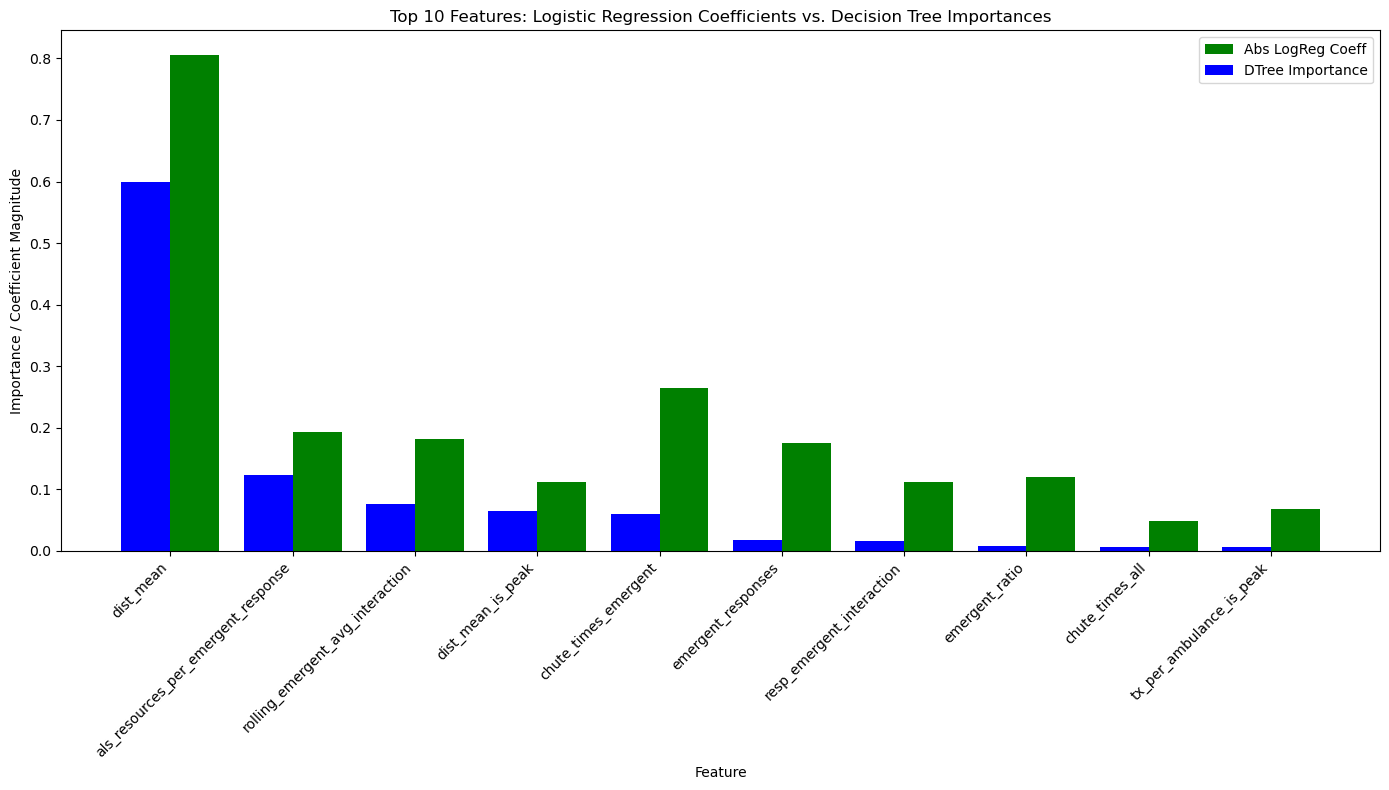

In [34]:
# Create DataFrame for Logistic Regression coefficients
logreg_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Abs_LogReg_Coeff': abs(best_model.named_steps['logreg'].coef_[0])
})

# Create DataFrame for Decision Tree feature importances
dtree_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'DTree_Importance': best_dtree.feature_importances_
})

# Merge the two DataFrames on the 'Feature' column
feature_comparison = pd.merge(
    logreg_coefficients, 
    dtree_importances, 
    on='Feature'
)

# Sort by Decision Tree importance or absolute logistic regression coefficient
feature_comparison = feature_comparison.sort_values(
    by=['DTree_Importance', 'Abs_LogReg_Coeff'], 
    ascending=False
)

# Display the combined table
print(feature_comparison)

# Plot side-by-side comparison of top 10 features
top_features = feature_comparison.head(10)

# Set up the plot
plt.figure(figsize=(14, 8))
x = np.arange(len(top_features))  # X positions for the bars
width = 0.4  # Width of the bars

# Bar plots for each metric
plt.bar(x + width/2, top_features['Abs_LogReg_Coeff'], width=width, color='green', label='Abs LogReg Coeff')
plt.bar(x - width/2, top_features['DTree_Importance'], width=width, color='blue', label='DTree Importance')

# Add feature labels and titles
plt.xticks(x, top_features['Feature'], rotation=45, ha='right')
plt.title('Top 10 Features: Logistic Regression Coefficients vs. Decision Tree Importances')
plt.xlabel('Feature')
plt.ylabel('Importance / Coefficient Magnitude')
plt.legend()
plt.tight_layout()
plt.show()

Kolmogorov-Smirnov Normality Test for dist_mean:
dist_mean - Compliant KS Test for Normality:
KS Statistic: 0.0757, P-Value: 0.0000
Reject the null hypothesis: dist_mean - Compliant is not normally distributed.

dist_mean - Non-Compliant KS Test for Normality:
KS Statistic: 0.0683, P-Value: 0.0000
Reject the null hypothesis: dist_mean - Non-Compliant is not normally distributed.



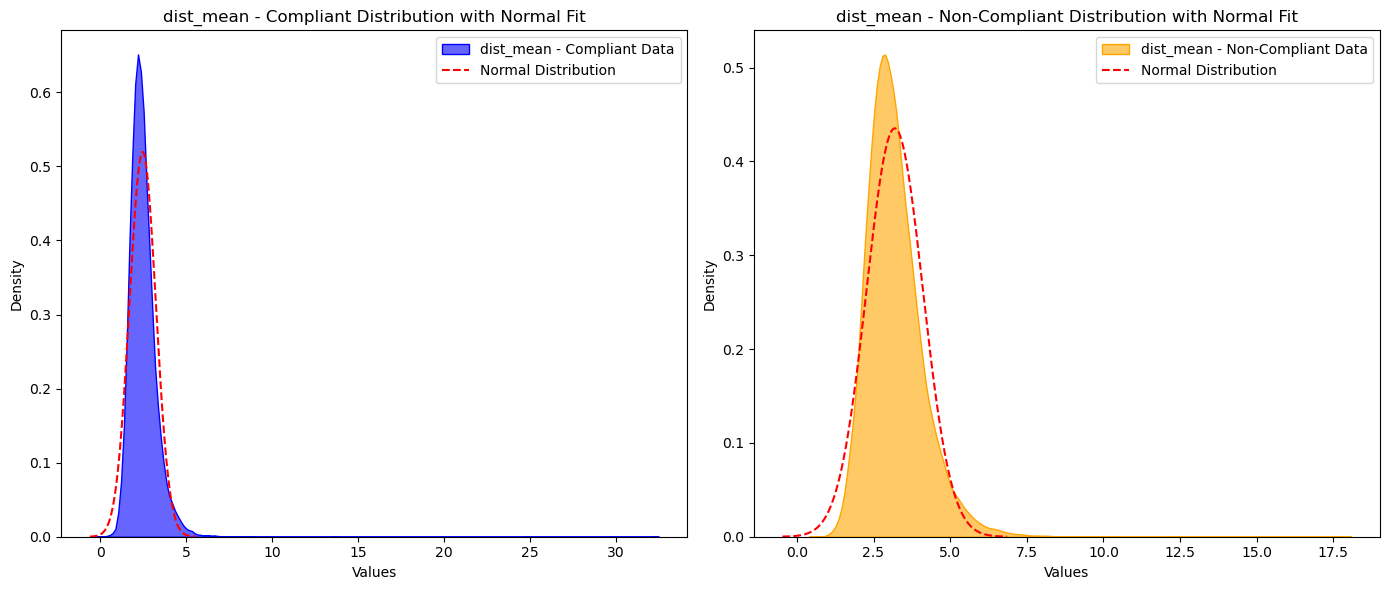

Mann-Whitney U Test for dist_mean (Testing Non-Compliant less than Compliant):
=== Mann-Whitney U Test Results ===
Testing Distribution of dist_mean - Compliant vs dist_mean - Non-Compliant
Alternative Hypothesis: 'less'
U Statistic: 157574213.0000
P-Value: 0.0000
Conclusion: dist_mean - Compliant is significantly smaller (distribution-wise) than dist_mean - Non-Compliant.


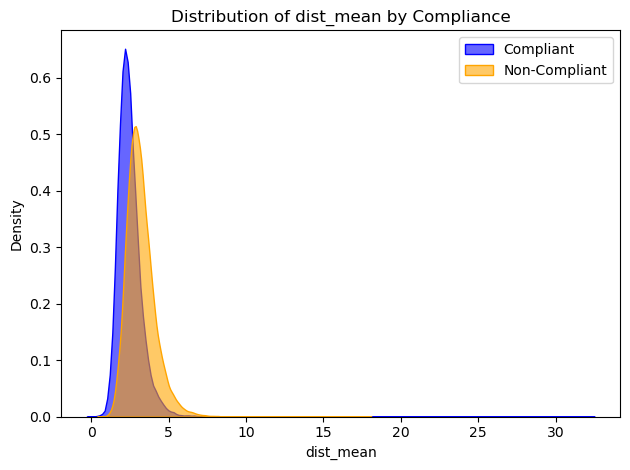

Compliant Median: 2.352031415698218
Non-Compliant Median: 3.057731568938425
Compliant Mean: 2.457592742968698
Non-Compliant Mean: 3.1916436040317193


In [42]:
feature_to_test = 'dist_mean'
alternative = 'less'

# Extract compliant and non-compliant groups
group1 = data[data['compliance'] == 1][feature_to_test].dropna()  # Compliant
group0 = data[data['compliance'] == 0][feature_to_test].dropna()  # Non-Compliant

# Kolmogorov-Smirnov Normality Test
print(f"Kolmogorov-Smirnov Normality Test for {feature_to_test}:")
ks_test_normality(group1, group0, group1_name=f"{feature_to_test} - Compliant", group0_name=f"{feature_to_test} - Non-Compliant")

# Mann-Whitney U Test
print(f"Mann-Whitney U Test for {feature_to_test} (Testing Non-Compliant {alternative} than Compliant):")
mann_whitney_test(group1, group0, group1_name=f"{feature_to_test} - Compliant", group0_name=f"{feature_to_test} - Non-Compliant", alternative=alternative)

# KDE Plot using the new function
plot_kde_with_groups(
    group1,
    group0,
    group1_name="Compliant",
    group0_name="Non-Compliant",
    title=f"Distribution of {feature_to_test} by Compliance",
    xlabel=feature_to_test,
    ylabel="Density"
)

# Summary Statistics
print("Compliant Median:", group1.median())
print("Non-Compliant Median:", group0.median())
print("Compliant Mean:", group1.mean())
print("Non-Compliant Mean:", group0.mean())

Kolmogorov-Smirnov Normality Test for chute_times_emergent:
chute_times_emergent - Compliant KS Test for Normality:
KS Statistic: 0.0711, P-Value: 0.0000
Reject the null hypothesis: chute_times_emergent - Compliant is not normally distributed.

chute_times_emergent - Non-Compliant KS Test for Normality:
KS Statistic: 0.0853, P-Value: 0.0000
Reject the null hypothesis: chute_times_emergent - Non-Compliant is not normally distributed.



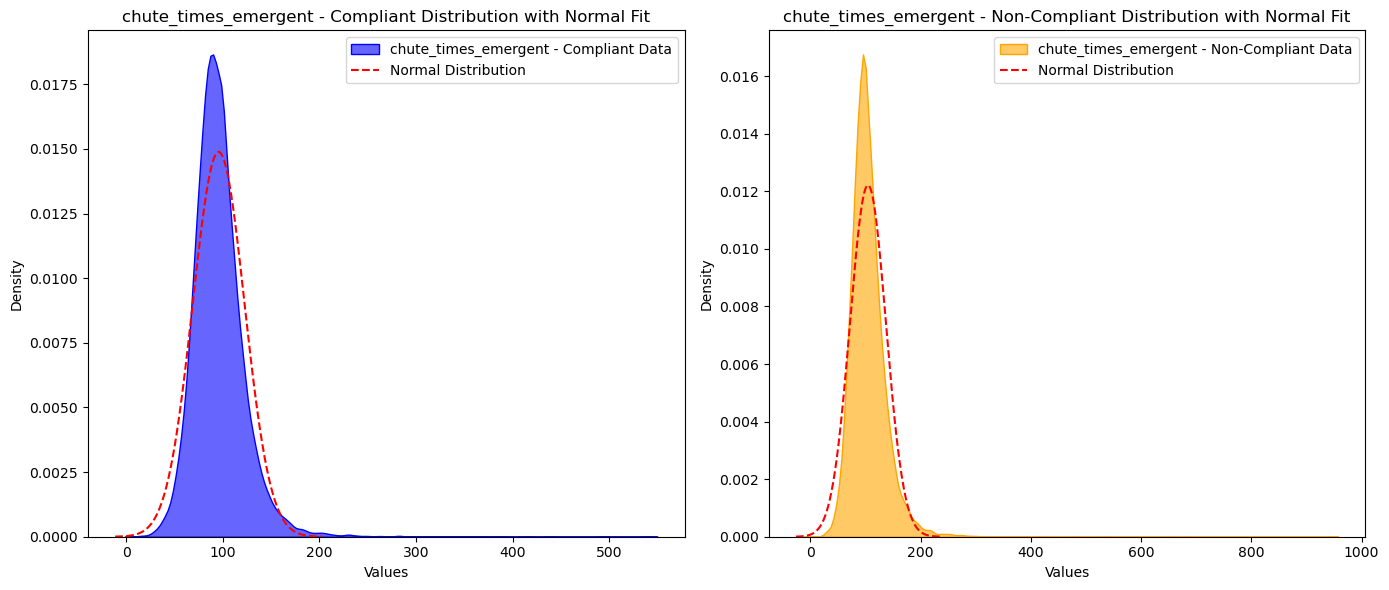

Mann-Whitney U Test for chute_times_emergent (Testing Non-Compliant less than Compliant):
=== Mann-Whitney U Test Results ===
Testing Distribution of chute_times_emergent - Compliant vs chute_times_emergent - Non-Compliant
Alternative Hypothesis: 'less'
U Statistic: 262892428.0000
P-Value: 0.0000
Conclusion: chute_times_emergent - Compliant is significantly smaller (distribution-wise) than chute_times_emergent - Non-Compliant.


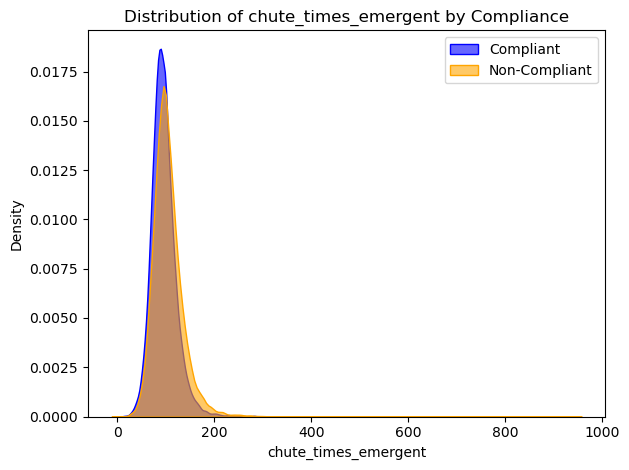

Compliant Median: 92.75
Non-Compliant Median: 99.77175
Compliant Mean: 95.54364499605748
Non-Compliant Mean: 104.47941547731394


In [44]:
feature_to_test = 'chute_times_emergent'
alternative = 'less'

# Extract compliant and non-compliant groups
group1 = data[data['compliance'] == 1][feature_to_test].dropna()  # Compliant
group0 = data[data['compliance'] == 0][feature_to_test].dropna()  # Non-Compliant

# Kolmogorov-Smirnov Normality Test
print(f"Kolmogorov-Smirnov Normality Test for {feature_to_test}:")
ks_test_normality(group1, group0, group1_name=f"{feature_to_test} - Compliant", group0_name=f"{feature_to_test} - Non-Compliant")

# Mann-Whitney U Test
print(f"Mann-Whitney U Test for {feature_to_test} (Testing Non-Compliant {alternative} than Compliant):")
mann_whitney_test(group1, group0, group1_name=f"{feature_to_test} - Compliant", group0_name=f"{feature_to_test} - Non-Compliant", alternative=alternative)

# KDE Plot using the new function
plot_kde_with_groups(
    group1,
    group0,
    group1_name="Compliant",
    group0_name="Non-Compliant",
    title=f"Distribution of {feature_to_test} by Compliance",
    xlabel=feature_to_test,
    ylabel="Density"
)

# Summary Statistics
print("Compliant Median:", group1.median())
print("Non-Compliant Median:", group0.median())
print("Compliant Mean:", group1.mean())
print("Non-Compliant Mean:", group0.mean())

Kolmogorov-Smirnov Normality Test for als_resources_per_emergent_response:
als_resources_per_emergent_response - Compliant KS Test for Normality:
KS Statistic: 0.1666, P-Value: 0.0000
Reject the null hypothesis: als_resources_per_emergent_response - Compliant is not normally distributed.

als_resources_per_emergent_response - Non-Compliant KS Test for Normality:
KS Statistic: 0.1193, P-Value: 0.0000
Reject the null hypothesis: als_resources_per_emergent_response - Non-Compliant is not normally distributed.



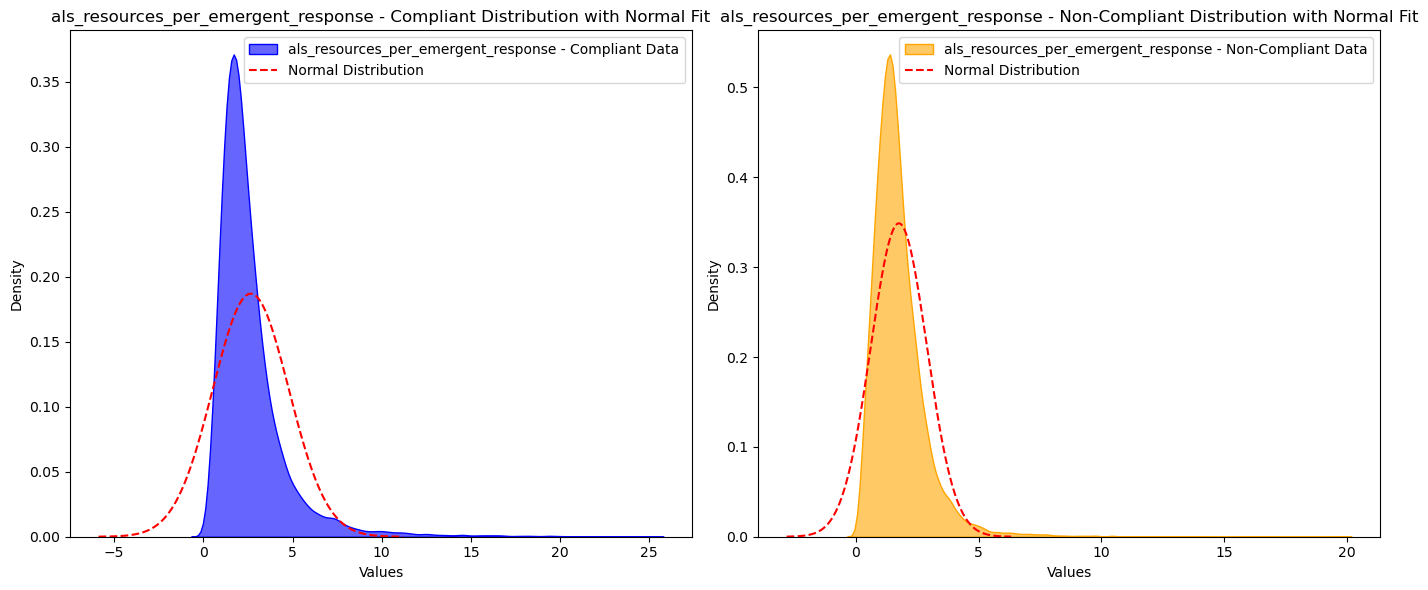

Mann-Whitney U Test for als_resources_per_emergent_response (Testing Non-Compliant greater than Compliant):
=== Mann-Whitney U Test Results ===
Testing Distribution of als_resources_per_emergent_response - Compliant vs als_resources_per_emergent_response - Non-Compliant
Alternative Hypothesis: 'greater'
U Statistic: 427814871.0000
P-Value: 0.0000
Conclusion: als_resources_per_emergent_response - Compliant is significantly larger (distribution-wise) than als_resources_per_emergent_response - Non-Compliant.


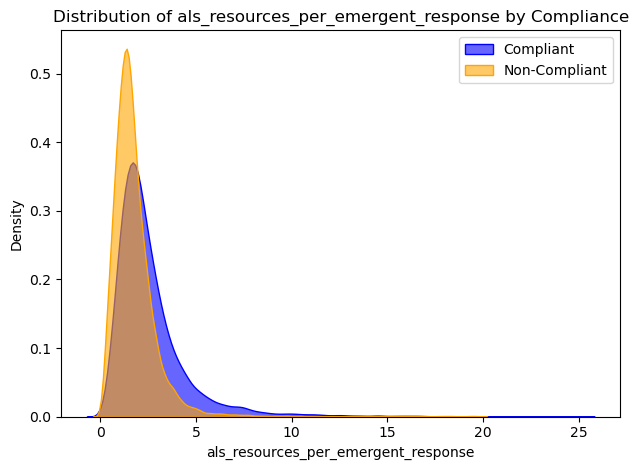

Compliant Median: 2.1194791666666664
Non-Compliant Median: 1.5278418803418803
Compliant Mean: 2.6609263841438584
Non-Compliant Mean: 1.7501895552128928


In [43]:
feature_to_test = 'als_resources_per_emergent_response'
alternative = 'greater'

# Extract compliant and non-compliant groups
group1 = data[data['compliance'] == 1][feature_to_test].dropna()  # Compliant
group0 = data[data['compliance'] == 0][feature_to_test].dropna()  # Non-Compliant

# Kolmogorov-Smirnov Normality Test
print(f"Kolmogorov-Smirnov Normality Test for {feature_to_test}:")
ks_test_normality(group1, group0, group1_name=f"{feature_to_test} - Compliant", group0_name=f"{feature_to_test} - Non-Compliant")

# Mann-Whitney U Test
print(f"Mann-Whitney U Test for {feature_to_test} (Testing Non-Compliant {alternative} than Compliant):")
mann_whitney_test(group1, group0, group1_name=f"{feature_to_test} - Compliant", group0_name=f"{feature_to_test} - Non-Compliant", alternative=alternative)

# KDE Plot using the new function
plot_kde_with_groups(
    group1,
    group0,
    group1_name="Compliant",
    group0_name="Non-Compliant",
    title=f"Distribution of {feature_to_test} by Compliance",
    xlabel=feature_to_test,
    ylabel="Density"
)

# Summary Statistics
print("Compliant Median:", group1.median())
print("Non-Compliant Median:", group0.median())
print("Compliant Mean:", group1.mean())
print("Non-Compliant Mean:", group0.mean())

## Recommendations